<a href="https://colab.research.google.com/github/Fjoelsak/pong-from-pixels/blob/THM-workshop/scripts/pong-from-pixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"> <img src="https://www.thm.de/_thm/logos/thm.svg" width="200"></p>

# Unsere challenge: Pong from pixles

Wir wollen im Folgenden den in der Vorlesung eingeführten Reinforcement learning Algorithmus **Vanilla Policy Gradients** auf die **Pong** Umgebung von OpenAI gym anwenden.
Anstatt ein package mit fertig implementierten Algorithmus zu laden, ist die Implementierung nochmals vorgegeben, damit wir verstehen was wirklich passiert.

![alt text](https://miro.medium.com/max/160/1*P4l2XZUffcJfJQjQ125wSw.gif?raw=true)



Zunächst installieren wir einige packages zur Visualisierung des Agenten im Umgebungsmodell. Dies ist leider in einem colab Notebook nicht direkt über die im gym interface implementierte render Methode möglich.

In [1]:
!pip install -q gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -q -y xvfb python-opengl ffmpeg > /dev/null 2>&1

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import base64

import numpy as np
import pickle as pickle

import gym
from gym import wrappers
from gym.wrappers import Monitor

# IO
from pathlib import Path

und definieren uns eine Funktion, die das aufgenommene Video wiedergibt.

In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("video").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 300px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

## Das Umgebungsmodell

wir initialisieren das Umgebungsmodell und schauen es uns zunächst noch einmal genauer an.

In [3]:
import gym

# initialize the gym environment
env = gym.make("Pong-v0")

# wrap the environment for visualization purposes
env = Monitor(env, './video', force=True, video_callable=lambda episode: True) 
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video()

Was passiert hier genau?

*   die Umgebung **initialisiert** und **reseten**. 
*   in der while-Schleife wird die jeweilige **action** des Agenten festgelegt und ein Zeitschritt (**step**) durchgeführt


das heißt, der Agent führt die Action im Umgebungsmodell aus, dass sich dementsprechend verändert. Zusätzlich wird ein reward-Signal ausgegeben. Done ist lediglich ein flag, ob das Ziel erreicht ist und info weitere Informationen zum Zeitschritt. 
In diesem einfachen Beispiel werden willkürlich actions gewählt und ausgeführt. Es liegt demnach ein Umgebungsmodell ohne lernenden Agenten vor.

Die Pong Umgebung ist eine von vielen Atari Umgebung, die eine gemeinsame Klasse als Ursprung haben. Dementsprechend ergibt sich auch das zunächst überraschende Ergebnis, dass der ```action_space``` aus sechs diskreten **actions** besteht. 

In [ ]:
print("Action:", env.action_space)
env.unwrapped.get_action_meanings()

Action: Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Hierbei hat action 0 keine Auswirkungen. Die Aktionen 2 und 4 haben ein Heraufschieben und die Aktionen 3 und 5 ein Herabschieben des eigenen Schlägers zur Folge.



Als **Observation** erhält der Agent ein 210x160 RGB Bild des Spiels (daher auch der Name pong from pixels). Mit 3 Farbwerten erhält man hier also einen Input von 100800 Pixel. 

In [ ]:
print("Observation", obs.shape)

Observation (210, 160, 3)


Später lässt sich das zu sehende Bild weiter optimieren, da einige Bereiche, wie das Scoreboard und der weiße Streifen nicht notwendig zum Lernen eine Spielstrategie sind. Weiterhin reicht es bspw. auch die beiden Schläger und den Ball zu erkennen, sodass eine grayscaling Ansicht völlig ausreicht. Später dazu mehr!

![alt text](https://miro.medium.com/max/160/1*TzrWM3-3l9EHr0oBXN3hnA.gif?raw=true)

Das **reward**-Signal, mit dem der Agent bestimmte Aktionen bewerten kann, ist hier einfach +1 für jede Runde, die der Agent gewinnt und -1 für jede Runde die der Computer gewinnt.

In [ ]:
print("Reward:", reward)

Reward: -1.0


## Policy Gradients

Im Folgenden wollen wir uns nochmals den Reinforcement learning Algorithmus Vanilla Policy Gradients aus der Vorlesung anschauen.

Zunächst einige Anmerkungen:

- Pong wird immer in einem Satz bis ein Mitspieler den Score 21 erreicht gespielt. Dementsprechend muss die Umgebung danach reseten werden und erst nachdem eine solche episode rum ist, wird ein Reward vergeben.
- der Input, den der Agent erhält (**observation**) sind optimierte Bilddaten aus dem Umgebungsmodell, dazu werden die Daten aus dem Umgebungsmodell zunächst vorbearbeitet (preprocessed)
- der Agent selbst lernt nicht mit diesen optimierten Bilddaten, sondern mit der Differenz zweier aufeinander folgender Bilder, dies hilft insbesondere bei der Architektur des vorliegenden Policy Netwerks Bewegungen mit einzubeziehen

### Preprocessing der Bilddaten

In [3]:
def prepro(I):
  """ preprocessing the 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
  I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
  I = I[::2,::2,0] # downsample by factor of 2.
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
  return I.astype(np.float).ravel() # ravel flattens an array and collapses it into a column vector

### Berechnen der rewards pro Episode

Nachdem eine Episode abgeschlossen ist, werden im Nachhinein von hinten nach vorne Belohnungen berechnet, um den letzten Aktionen der Episode eine größere Bedeutung zuzuordnen (siehe Bild unten).

$$ R(\tau) = \sum_{n=0}^H \gamma^n r_{t-n} $$

wenn $\tau$ die Episode darstellt mit $H$ Zeitschritten im Intervall $[t-n, t]$.

<p align="left"> <img src="https://miro.medium.com/max/1296/1*ULZuiQPZT3KpznvQFs1GZg.png" width="600"></p>



In [4]:
def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  """ this function discounts from the action closest to the end of the completed game backwards
  so that the most recent action has a greater weight """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)): 
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!), we are currently at the end of an episode
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

### Policy Network

Als stochastische Policy dient ein einfaches Neuronales Netz mit einem hidden layer (trotz nur einem hidden layer wird hier oftmals bereits von **Deep Reinforcement Learning** geredet).

Als Input dienen die Bilddaten mit $75\cdot 80 = 6000$ Pixeln. Diese werden mittels den Gewichten des hidden layers auf $200$ Ausgänge der Neuronen abgebildet und mit der Rectifier Funktion "aktiviert".
Anschließend werden die Ausgänge des hidden layers mit dem letzten Layer des Netzwerks auf einen Skalar abgebildet.
Um letztlich eine Wahrscheinlichkeit für die Up bzw. Down Bewegung des Schlägers zu erhalten wird letztlich die sigmoid Funktion verwendet.


<p align="left"> <img src="https://miro.medium.com/max/966/1*05ExQKJ0nOoWV80SNVEyJg.png" width="500"></p>



In [5]:
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1] required to obtain a propability

def policy_forward(x):
  """This is a manual implementation of a forward prop"""
  h = np.dot(model['W1'], x) # (H x D) . (D x 1) = (H x 1) (200 x 1)
  h[h<0] = 0 # ReLU introduces non-linearity
  logp = np.dot(model['W2'], h) # This is a logits function and outputs a decimal.   (1 x H) . (H x 1) = 1 (scalar)
  p = sigmoid(logp)  # squashes output to  between 0 & 1 range
  return p, h # return probability of taking action 2 (UP), and hidden state

def policy_backward(eph, epx, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  """ Manual implementation of a backward prop"""
  """ It takes an array of the hidden states that corresponds to all the images that were
  fed to the NN (for the entire episode, so a bunch of games) and their corresponding logp"""
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

### Trainieren des Agenten

Das Trainieren des Agenten kann längere Zeit in Anspruch nehmen. Da colab nach 90 min idle time von der Laufzeitumgebung automatisch disconnected, ist es sinnvoll das Modell und entsprechende Daten, die man analysieren möchte zwischenzuspeichern. Dies ist hier über google drive umgesetzt.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
Path = F"/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
""" Majority of this code was copied directly from Andrej Karpathy's gist:
https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5 """

""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """

#################################################
# hyperparameters
#################################################
H = 200 # number of hidden layer neurons
batch_size = 10 # used to perform a RMS prop param update every batch_size steps
learning_rate = 1e-3 # learning rate used in RMS prop
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2

# Config flags - video output and resume
resume = True # resume training from previous checkpoint (from save.p file)?

#####################################################################
# main program - train the agent
#####################################################################

# model initialization
D = 75 * 80 # input dimensionality: 75x80 grid
if resume:
  model = pickle.load(open(Path+'PG-agent-pong.p', 'rb'))
  reward_overTime = pickle.load(open(Path+'PG-agent-pong-RoT.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization - Shape will be H x D (H x 6000) normalized with sqrt(D)
  model['W2'] = np.random.randn(H) / np.sqrt(H) # Shape will be H

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

env = gym.make("Pong-v0")
env = wrappers.Monitor(env, './video', force=True, video_callable=lambda episode_id: episode_id%1000==0)
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogp,drs = [],[],[],[]
reward_overTime = []
running_reward = None
reward_sum = 0
episode_number = 0

while episode_number < 10000:

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  # we take the difference in the pixel input, since this is more likely to account for interesting information
  # e.g. motion
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  upProbability, h = policy_forward(x)
  # The following step is randomly choosing a number which is the basis of making an action decision
  # If the random number is less than the probability of UP output from our neural network given the image
  # then go up.  The randomness introduces 'exploration' of the Agent
  action = 2 if np.random.uniform() < upProbability else 3 # roll the dice! 2 is UP, 3 is DOWN, 0 is stay the same

  # record various intermediates (needed later for backprop).
  # This code would have otherwise been handled by a NN library
  xs.append(x) # observation
  hs.append(h) # hidden state
  fake_label = 1 if action == 2 else 0 # a "fake label" - this is the label that we're passing to the neural network
  # to fake labels for supervised learning. It's fake because it is generated algorithmically, and not based
  # on a ground truth, as is typically the case for Supervised learning

  dlogp.append(fake_label - upProbability) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward
  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogp)
    epr = np.vstack(drs)
    xs,hs,dlogp,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (Policy Grad magic happens right here.)
    gradient = policy_backward(eph, epx, epdlogp)
    for k in model: grad_buffer[k] += gradient[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % 50 == 0: print ('episode_number', episode_number, 'resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
    reward_overTime.append(reward_sum) 
    if episode_number % 200 == 0: 
      pickle.dump(model, open(Path+'PG-agent-pong.p', 'wb'))
      pickle.dump(reward_overTime, open(Path+'PG-agent-pong-RoT.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  #if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
    #print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

show_video()

episode_number 50 resetting env. episode reward total was -7.000000. running mean: -12.049913
episode_number 100 resetting env. episode reward total was -10.000000. running mean: -12.431131
episode_number 150 resetting env. episode reward total was -15.000000. running mean: -12.749583
episode_number 200 resetting env. episode reward total was -13.000000. running mean: -12.854347
episode_number 250 resetting env. episode reward total was -13.000000. running mean: -13.040343
episode_number 300 resetting env. episode reward total was -9.000000. running mean: -12.969523
episode_number 350 resetting env. episode reward total was -9.000000. running mean: -13.021705
episode_number 400 resetting env. episode reward total was -15.000000. running mean: -13.079540
episode_number 450 resetting env. episode reward total was -8.000000. running mean: -12.810045
episode_number 500 resetting env. episode reward total was -18.000000. running mean: -12.556227
episode_number 550 resetting env. episode rew

### Reward über Episoden ("Lernrate")

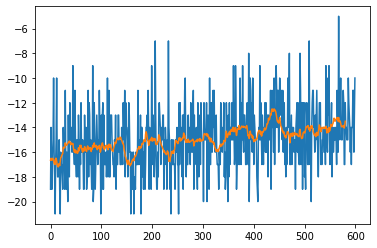

In [7]:
import matplotlib.pyplot as plt

reward_overTime = pickle.load(open(Path+'PG-agent-pong-RoT.p', 'rb'))
  
window = 20
episodes = len(reward_overTime)
plt.plot(reward_overTime[:episodes])
plt.plot(np.convolve(reward_overTime[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

### Testen des Agenten

In [ ]:
import gym

# initialize the gym environment
env = gym.make("Pong-v0")

# wrap the environment for visualization purposes
env = Monitor(env, './video', force=True, video_callable=lambda episode: True) 
env.reset()

model = pickle.load(open('save.p', 'rb'))

done = False
while not done:
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  # we take the difference in the pixel input, since this is more likely to account for interesting information
  # e.g. motion
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  upProbability, h = policy_forward(x)
  # The following step is randomly choosing a number which is the basis of making an action decision
  # If the random number is less than the probability of UP output from our neural network given the image
  # then go up.  The randomness introduces 'exploration' of the Agent
  action = 2 if np.random.uniform() < upProbability else 3 # roll the dice! 2 is UP, 3 is DOWN, 0 is stay the same
  obs, reward, done, info = env.step(action)
env.close()
show_video()

References:

https://towardsdatascience.com/intro-to-reinforcement-learning-pong-92a94aa0f84d

[http://karpathy.github.io/2016/05/31/rl/](http://karpathy.github.io/2016/05/31/rl/)